In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)    # (B, 32, H, W)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # (B, 64, H/2, W/2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # (B, 128, H/4, W/4)
        self.dropout1 = nn.Dropout(0.3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # (B, 128, H/8, W/8)
        self.dropout2 = nn.Dropout(0.3)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)  # (B, 64, H/16, W/16)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, padding=1)   # (B, 32, H/32, W/32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))        # global average pool
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B, 32, H/2, W/2)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 64, H/4, W/4)
        x = self.pool(F.relu(self.conv3(x)))  # (B, 128, H/8, W/8)
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv4(x)))  # (B, 128, H/16, W/16)
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv5(x)))  # (B, 64, H/32, W/32)
        x = self.pool(F.relu(self.conv6(x)))  # (B, 32, H/64, W/64)
        x = self.global_avg_pool(x)          # (B, 32, 1, 1)
        x = x.view(x.size(0), -1)            # (B, 32)
        x = F.relu(self.fc1(x))              # (B, 64)
        x = self.fc2(x)                      # (B, num_classes)
        return x

In [3]:
# Set seed for reproducibility
torch.manual_seed(0)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle


In [5]:
# 2. Data Preparation
def load_data():
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=True)


    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)
    return train_loader, test_loader

# 3. Training Function
def train_model(model, loader, optimizer, criterion, epochs=10):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}")

    return loss_history

# 4. Evaluation
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = load_data()

model = BaselineCNN(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

start = time.time()
loss_history = train_model(model, train_loader, optimizer, criterion, epochs=10)
end = time.time()

print(f"Training completed in {end - start:.2f} seconds")

test_acc = evaluate_model(model, test_loader)

Epoch 1/10 - Loss: 1.2752
Epoch 2/10 - Loss: 0.7440
Epoch 3/10 - Loss: 0.6142
Epoch 4/10 - Loss: 0.5086
Epoch 5/10 - Loss: 0.4362
Epoch 6/10 - Loss: 0.3968
Epoch 7/10 - Loss: 0.3316
Epoch 8/10 - Loss: 0.2934
Epoch 9/10 - Loss: 0.2489
Epoch 10/10 - Loss: 0.2412
Training completed in 344.60 seconds
Test Accuracy: 91.81%


In [7]:
# print how many parameters the model has
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 335850


In [11]:
#print the model weight
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.data.mean():.4f} (std: {param.data.std():.4f})")
    # save to a dictionary and print it

model_weights = {name: (param.data.mean().item(), param.data.std().item()) for name, param in model.named_parameters() if param.requires_grad}
print(model_weights)

conv1.weight: 0.0026 (std: 0.1211)
conv1.bias: -0.0445 (std: 0.1065)
conv2.weight: -0.0140 (std: 0.0653)
conv2.bias: -0.0187 (std: 0.0673)
conv3.weight: -0.0144 (std: 0.0610)
conv3.bias: -0.0263 (std: 0.0768)
conv4.weight: -0.0124 (std: 0.0565)
conv4.bias: -0.0090 (std: 0.0918)
conv5.weight: -0.0101 (std: 0.0538)
conv5.bias: 0.0087 (std: 0.1234)
conv6.weight: -0.0073 (std: 0.0442)
conv6.bias: 0.0276 (std: 0.1409)
fc1.weight: -0.0010 (std: 0.1099)
fc1.bias: 0.0687 (std: 0.1659)
fc2.weight: -0.0258 (std: 0.1092)
fc2.bias: -0.0102 (std: 0.1818)
{'conv1.weight': (0.002619123551994562, 0.12110346555709839), 'conv1.bias': (-0.044515371322631836, 0.10650832951068878), 'conv2.weight': (-0.014031852595508099, 0.06525229662656784), 'conv2.bias': (-0.01866402104496956, 0.06726235151290894), 'conv3.weight': (-0.014420724473893642, 0.06095079332590103), 'conv3.bias': (-0.026280079036951065, 0.07677483558654785), 'conv4.weight': (-0.012442529201507568, 0.056499700993299484), 'conv4.bias': (-0.009047

In [9]:
#print accuracy
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 91.81%


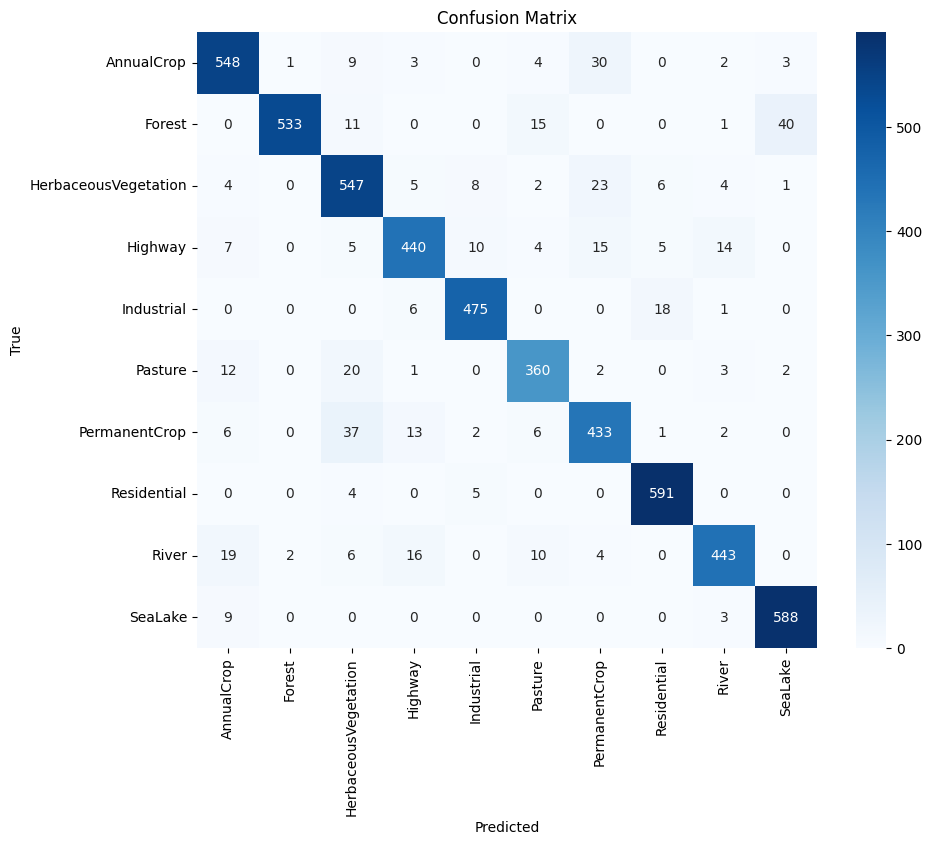

In [ ]:
# show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Get true labels and predictions
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

# Plot confusion matrix
classes = train_loader.dataset.dataset.classes  
plot_confusion_matrix(y_true, y_pred, classes)
